# Анализ воронки событий мобильного приложения и анализ A/A/B-теста

## Оглавление <a id="оглавление"></a>

1. [Шаг 1. Изучение и предобработка данных](#Шаг_1)
1. [Шаг 2. Анализ воронки событий](#Шаг_2)
1. [Шаг 3. А/А/В-тест и анализ результатов](#Шаг_3)
1. [Шаг 4. Выводы по результатам теста и анализу воронки событий](#Шаг_4)

## Описание проекта <a id="описание"></a>

**Заказчик:** Стартап, который продает продукты питания.

**Продукт:** Мобильное приложение для заказов продуктов питания
<br>

**Цели:**
1. Определить точки оптимизации пути пользователей до покупки
2. Принять решение о смене шрифтов в приложении (есть предположение, что пользователям новые шрифты будут мешать)
<br>

<br>

**Задачи**:
1. Изучить пользователей. Rак доходят до покупки? Cколько пользователей доходит? Сколько пользователей "отваливаются" на разных этапах воронки? Где отваливаются?
2. Изучить результаты A/A/B-эксперимента: влияет ли шрифт на проходимость воронки?
<br>

<br>

**Данные:** логи мобильного приложения с действиями пользователей (каждая запись — событие). <br>
+ EventName — название события
+ DeviceIDHash — уникальный идентификатор пользователя
+ EventTimestamp — время события
+ ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
<br>

<br>

**Важные замечания:** <br>
Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». <br>
Нужно, определить период с полными и актуальными данными.

## Шаг 1. Изучение и предобработка данных <a id="Шаг_1"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion1)

In [1]:
# импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import math as mt
import datetime as dt
import plotly.express as px
from plotly import graph_objects as go 

plt.style.use('seaborn') 

pd.options.display.float_format = '{: .2f}'.format

import warnings
warnings.filterwarnings('ignore')

In [2]:
# изучаем данные

df = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Столбец EventTimestamp содержит время в формате unixtime - это число секунд с 1970-01-01. <br>
Нужно перевести его в "нормальный"

Также отдельно добавим столбец с датой события и изменим названия столбцов на более удобные.

In [3]:
# приведем дату события к нормальному виду: с датой и временем
df['EventTimestamp'] = pd.to_datetime(df['EventTimestamp'], unit='s').rename(columns = {'EventTimestamp': 'date_time'})

# создадим столбец с датой события
df['date'] = pd.to_datetime(df['EventTimestamp'].astype('datetime64[D]'))

# переименуем столбцы
df = df.rename(columns = {'EventTimestamp': 'date_time', 'EventName': 'event', 'DeviceIDHash': 'userid', 'ExpId': 'testgroup'})

# проверим, что получилось
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
event        244126 non-null object
userid       244126 non-null int64
date_time    244126 non-null datetime64[ns]
testgroup    244126 non-null int64
date         244126 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Новые столбцы создались правильно и в нужномт типе данных.

Дале проверим, есть ли пропуски и дубликаты.

In [4]:
print('\n' + 'Количество пропусков в таблице:')
df.isna().sum()


Количество пропусков в таблице:


event        0
userid       0
date_time    0
testgroup    0
date         0
dtype: int64

В таблице нет пропусков ни в одной колонке.

In [5]:
print('\n' + 'Количество дубликатов в таблице:', df.duplicated().sum())
print('\n' + 'Доля дубликатов от всех данных:', round(df.duplicated().sum() / len(df), 5))


Количество дубликатов в таблице: 413

Доля дубликатов от всех данных: 0.00169


В таблице есть полные дубликаты и они составляют очень малую долю от всех данных.

Удалим их.

In [6]:
df = df.drop_duplicates()
print('\n' + 'Количество дубликатов в таблице:', df.duplicated().sum())


Количество дубликатов в таблице: 0


Дубликатов в таблице не осталось.

Проверим, нет ли пересечения по пользователям между группами.

In [7]:
# для каждого пользователя посчитаем кол-во уникальных групп, в которые он попал
# соберем список всех пользователей, которые есть сразу в двух группах

both_group_users = df.groupby('userid').agg({'testgroup': 'nunique'}).query('testgroup > 1').reset_index()

both_group_users.count()

userid       0
testgroup    0
dtype: int64

Группы не пересекаются.

**Изучим сколько в логах событий и пользователей и сколько событий приходится на одного пользователя.**

Сколько всего событий в логе?

Сколько всего пользователей в логе?

Сколько в среднем событий приходится на пользователя?

Посчитаем количество событий в логе.

In [8]:
events = df.event.value_counts().reset_index()
events = events.rename(columns = {'index': 'event', 'event': 'qnt'})
events

,event,qnt
0,MainScreenAppear,119101
1,OffersScreenAppear,46808
2,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Всего в логах 5 разных событий о появлении разных экранов приложения:
1. Главный экран (MainScreenAppear)
2. Экран с товаром (MainScreenAppear)
3. Экран корзины (CartScreenAppear)
4. Экран успешной оплаты (PaymentScreenSuccessful)
5. Экран с обучением (Tutorial) — на этот экран переходят реже всего

In [9]:
event_num = df.event.value_counts().sum()
print('\n' + 'Общее количество событий в логах:', event_num)


Общее количество событий в логах: 243713


Посчитаем кол-во уникальных пользователей в логах.

In [10]:
user_num = df.userid.nunique()
print('\n' + 'Количество уникальных пользователей в логах:', user_num)


Количество уникальных пользователей в логах: 7551



Среднее кол-во событий на пользователя: 32.3

Медианное кол-во событий на пользователя: 20


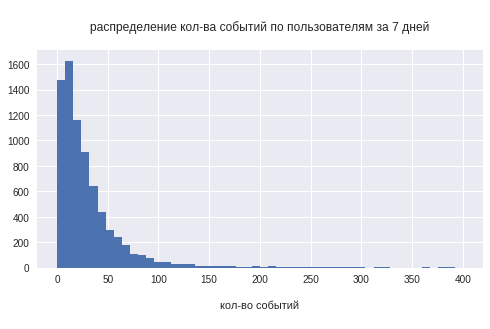

In [11]:
print('\n' + 'Среднее кол-во событий на пользователя:', round(event_num / user_num, 1))

print('\n' + 'Медианное кол-во событий на пользователя:', round(df.groupby('userid').agg({'event': 'count'}).median()[0]))

df.groupby('userid').agg({'event': 'count'}).hist(bins = 50, figsize=(8, 4), range = (0, 400))
plt.title('\n' + 'распределение кол-ва событий по пользователям за 7 дней' + '\n')
plt.xlabel('\n' + 'кол-во событий' + '\n')
plt.show()

Медиана меньше, чем среднее значение.

Данные скошены вправо: есть длинные хвост из пользователей, которые очень часто пользуются приложением и генерирует множество событий в логах.

Основная доля пользователей совершает до 50 действий за неделю.

In [12]:
# посмотрим, сколько событий каждого вида в среднем совершают пользователи

print('\n' + 'Среднее кол-во открытых главных экранов:',
      round(events.query('event == "MainScreenAppear"').qnt[0] / user_num, 2))

print('\n' + 'Среднее кол-во открытых экранов с товарами:',
      round(events.query('event == "OffersScreenAppear"').qnt[1] / user_num, 2))

print('\n' + 'Среднее кол-во открытых корзин на пользователя:',
      round(events.query('event == "CartScreenAppear"').qnt[2] / user_num, 2))

print('\n' + 'Среднее кол-во оплат (заказов) на пользователя:',
      round(events.query('event == "PaymentScreenSuccessful"').qnt[3] / user_num, 2))

print('\n' + 'Среднее кол-во переходов в обучение:',
      round(events.query('event == "Tutorial"').qnt[4] / user_num, 2))


Среднее кол-во открытых главных экранов: 15.77

Среднее кол-во открытых экранов с товарами: 6.2

Среднее кол-во открытых корзин на пользователя: 5.65

Среднее кол-во оплат (заказов) на пользователя: 4.52

Среднее кол-во переходов в обучение: 0.13


В среднем за неделю пользователи заходят в приложение около 15 раз.

Однако просматривают товары в 2,5 раза реже. <br>
Конверсия из открытия приложения в просмотр товара низкая.

Стоит изучить поведение пользователей, которые открывают главный экран и больше ничего не делают, и попытаться выяснить, почему они так себя ведут: им не интересно? не могут найти то, что нужно? и т.д.

**Проверим актуальность и полноту данных.**

Данными за какой период вы располагаете? Найдите максимальную и минимальную дату.

Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период?

Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?

In [13]:
df.date.describe()

count                  243713
unique                     14
top       2019-08-01 00:00:00
freq                    36141
first     2019-07-25 00:00:00
last      2019-08-07 00:00:00
Name: date, dtype: object

Данные за период с 25 июля 2019 по 7 августа 2019.

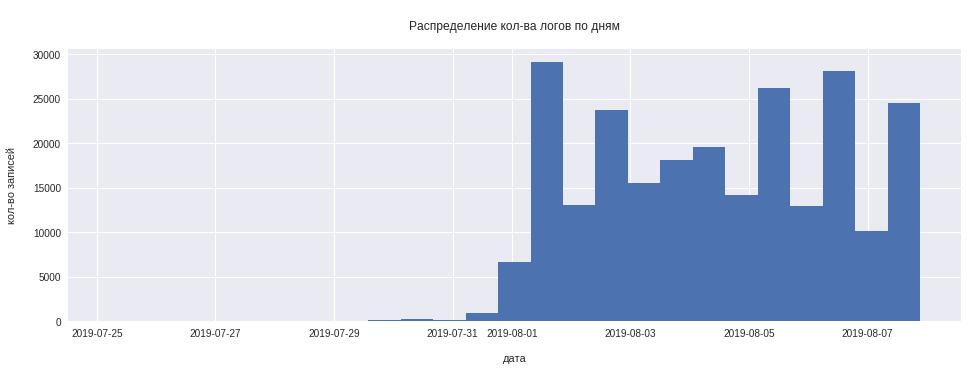

In [14]:
plt.figure(figsize=(16, 5))
df.date_time.hist(bins = 25)
plt.xlabel('\n' + 'дата')
plt.ylabel('кол-во записей' + '\n')
plt.title('\n' + 'Распределение кол-ва логов по дням' + '\n')
plt.show()

По распределению кол-ва записей в логах по дням видно, что большая часть записей находится в периоде между 1 и 7 августа.

Посмотрим на это распределение поближе.

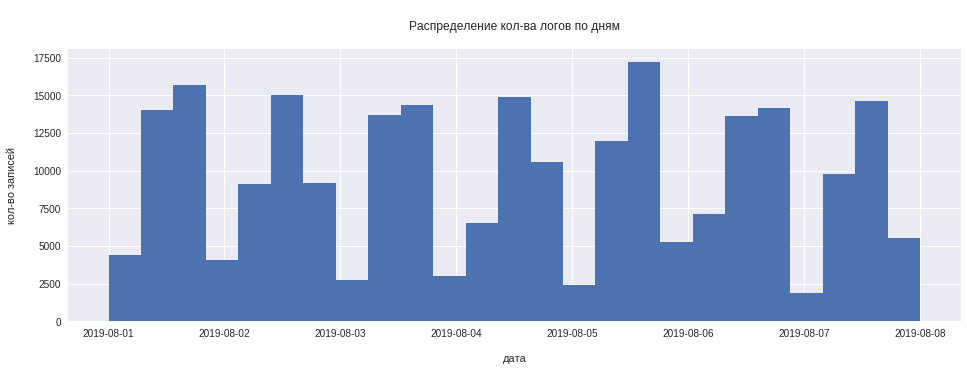

In [15]:
plt.figure(figsize=(16, 5))
df.date_time.hist(bins = 25, range = ('2019-08-01 00:00:00', '2019-08-07 23:59:59'))

plt.xlabel('\n' + 'дата')
plt.ylabel('кол-во записей' + '\n')
plt.title('\n' + 'Распределение кол-ва логов по дням' + '\n')
plt.show()

Распределение выглядит адекватно. Провалы в кол-ве записей "ритмичны": скорее всего это снижение кол-ва посещений приложения в выходные.

Проверим, какую долю от всех данные составляют записи июля и обновим датафрейм.

In [16]:
print('\n' + 'Всего записей в датафрейме:', len(df))
print('Доля устаревших записей:', round(len(df.query('date < "2019-08-01"')) / len(df), 2))
print('Всего удалим записей:', len(df.query('date < "2019-08-01"')))
print('Кол-во оставшихся записей:', len(df) - len(df.query('date < "2019-08-01"')), '\n')



print('\n' + 'Всего пользователей в датафрейме', df.userid.nunique())
print('Доля удаляемых пользователей:', round((df.userid.nunique() - df.query('date > "2019-07-31"').userid.nunique()) / df.userid.nunique(), 4))
print('Всего удалим пользователей:', df.userid.nunique() - df.query('date > "2019-07-31"').userid.nunique())
print('Кол-во оставшихся пользователей:', df.query('date > "2019-07-31"').userid.nunique(), '\n')


Всего записей в датафрейме: 243713
Доля устаревших записей: 0.01
Всего удалим записей: 2826
Кол-во оставшихся записей: 240887 


Всего пользователей в датафрейме 7551
Доля удаляемых пользователей: 0.0023
Всего удалим пользователей: 17
Кол-во оставшихся пользователей: 7534 



Доля устаревших записей совсем небольшая.

Обновим датафрейм.

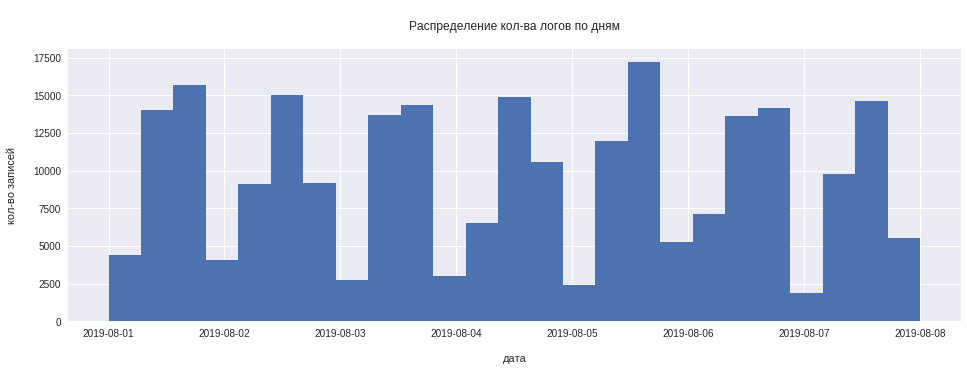

In [17]:
df = df.query('date > "2019-07-31"')

plt.figure(figsize=(16, 5))
df.date_time.hist(bins = 25, range = ('2019-08-01 00:00:00', '2019-08-07 23:59:59'))

plt.xlabel('\n' + 'дата')
plt.ylabel('кол-во записей' + '\n')
plt.title('\n' + 'Распределение кол-ва логов по дням' + '\n')
plt.show()

Проверим, сколько пользователей в каждой группе осталось.

In [18]:
df.groupby('testgroup').agg({'userid': 'nunique'})

,userid
testgroup,
246,2484
247,2513
248,2537


Пользователи распределены между группами примерно в равных пропорциях и такого распределения будет достаточно для A/A/B-теста.

### Результаты предобработки <a id="conclusion1"></a>

1. Создали столбцы с датой и временем события (вместе и дата отдельно)
2. Заменили названия столбоц на более удобные
3. Проверили, есть ли пропуски: их не оказалось
4. Удалили полные дубликаты
5. Столбцы с датами привели к нужному типу данных
6. Проверили тестовые группы на пересечение по пользователям: пересечений нет
7. Определили кол-во событий в логах: 5 уникальных событий о посещении ключевых экранов приложения
8. Определили кол-во событий на пользователя: средний пользователей совершает 32 действия (за две недели)
9. Очистили датафрейм от устаревших данных и за актуальный период взяли первую неделю августа
10. Удостоверились, что после очистки распределение пользователей по группам осталось достаточным для проведения теста

***

## Шаг 2. Анализ воронки событий <a id="Шаг_2"></a>
[К оглавлению](#оглавление)<br>
[К выводам по шагу](#conclusion2)

+ Определим последовательность событий в воронке
+ Изучим конверсию из события в событие
+ Узнаем, какая доля пользователей успешно доходит до оплаты заказа

Посмотрим, сколько событий осталось в очищенных логах, как часто они встречаются и сколько пользователей их совершали.

Также от общего числа пользователей найдем долю совершивших каждое из действий.

In [19]:
# найдем кол-во всех событий и кол-во уникальных пользователей, которые их совершили
events_count = (df
                    .groupby('event')
                    .agg(users_performed = ('userid', 'nunique'),count = ('userid', 'count'))
                .sort_values('count', ascending = False)
               )

# посчитаем долю пользователей совершивших каждое событие
events_count['users_share_of_total'] = events_count.users_performed / df.userid.nunique()


events_count

,users_performed,count,users_share_of_total
event,,,
MainScreenAppear,7419,117328,0.98
OffersScreenAppear,4593,46333,0.61
CartScreenAppear,3734,42303,0.50
PaymentScreenSuccessful,3539,33918,0.47
Tutorial,840,1005,0.11


Только 98,5% пользователей посещают главный экран, хотя его нельзя пропустить при открытии приложения.<br>
Скорее всего такое значение возникло из-за удалений устаревших данных.

Часть оставшихся пользователей в очищенном датасете проходили первый этап воронки еще в июле, но мы их удалили и в августе не у всех пользователей первый этап оказался пройденным.

61% всех пользователей действительно интересуются товарами в приложении (переходят на страницу товара).

Только около половины всех пользователей что-то заказывают. Остальные 43% пользователей за неделю еще ничего не покупали.

Нормально это или нет — зависит от того, как часто, пользователи, которые покупают, делают заказы (ведь цикл покупки может быть дольше недели).

Можно это проверить. <br>
Мы знаем, что у нас есть данные за неделю. Посмотрим, сколько заказов в среднем делают пользователи за неделю.

In [20]:
print(
        '\n' + 'Количество покупок в неделю у половины пользователей:',
df.query('event == "PaymentScreenSuccessful"').groupby('userid').agg({'event': 'count'}).median()[0]
    )


Количество покупок в неделю у половины пользователей: 4.0


Половина пользователей совершает больше 1 покупки в неделю.

Значит цикл покупки точно короче 7 дней.

Следовательно, мы имеем низкую долю платящих пользователей в нашем датасете не из-за этого.

Половина пользователей действительно не хочет совершать заказы.

Обучение (Tutorial) — необязательный этап приложения, его проходит всего 11% всех пользователей. <br>
Поэтому этот этап можно исключить из воронки.

Остальные события складываются в логичную последовательность:
1. пользователь попадает на главный экран приложения
2. затем переходит на страницу товара
3. кладет товар в корзину
4. оплачивает заказ

При этом пользователь может класть несколько разных товаров в корзину и переходить между корзиной и карточкой товара несколько раз (класть товар в корзину, смотреть корзину, снова возвращаться к карточке товара и снова в корзину). <br>

Поэтому для анализа пользователей лучше использовать простую воронку, а не воронку с последовательностью.

Посмотрим на эту воронку.

In [91]:
# визуализируем  общую воронку
fig = go.Figure(go.Funnel(
    
    y = [
         "Всего пользователей  ",
         "Просмотр главного экрана  ",
         "Просмотр страницы товара  ",
         "Переход в корзину (оформление заказа)  ",
         "Успешная оплата  "
        ],
    
    x = [
         df.userid.nunique(),
         events_count.users_performed.MainScreenAppear,
         events_count.users_performed.OffersScreenAppear,
         events_count.users_performed.CartScreenAppear,
         events_count.users_performed.PaymentScreenSuccessful
        ],
    
    textinfo = "value+percent previous"
                        )
               )

fig.update_layout(title = '\n' + 'Переходы пользователей между разными экранами приложения (проценты — доля от предыдущего шага)')

fig.update_traces(hovertemplate='от всех пользователей: %{percentInitial} <br> от прошлого шага: %{percentPrevious}')

fig.show()




# визуализируем воронку в разбивке по группам

# создадим таблицу, где для каждой группы посчитаем кол-во каждого события

events_by_group = (df
                    .groupby(['testgroup', 'event'])
                    .agg(users_performed = ('userid', 'nunique'))
                    ).query('event != "Tutorial"').sort_values(['testgroup', 'users_performed'], ascending = False).reset_index()

fig = go.Figure()

fig.add_trace(go.Funnel(
    
    name = 'A (246)',
    
    y = [
         "Всего пользователей  ",
         "Просмотр главного экрана  ",
         "Просмотр страницы товара  ",
         "Переход в корзину (оформление заказа)  ",
         "Успешная оплата  "
        ],
    
    x = [
         df.query('testgroup == 246').userid.nunique(),
         int(events_by_group.query('testgroup == 246')['users_performed'][8]),
         int(events_by_group.query('testgroup == 246')['users_performed'][9]),
         int(events_by_group.query('testgroup == 246')['users_performed'][10]),
         int(events_by_group.query('testgroup == 246')['users_performed'][11])
        ],
    
    textinfo = "value+percent previous")
             )

fig.add_trace(go.Funnel(
    
    name = 'A (247)',
    
    y = [
         "Всего пользователей  ",
         "Просмотр главного экрана  ",
         "Просмотр страницы товара  ",
         "Переход в корзину (оформление заказа)  ",
         "Успешная оплата  "
        ],
    
    x = [
         df.query('testgroup == 247').userid.nunique(),
         int(events_by_group.query('testgroup == 247')['users_performed'][4]),
         int(events_by_group.query('testgroup == 247')['users_performed'][5]),
         int(events_by_group.query('testgroup == 247')['users_performed'][6]),
         int(events_by_group.query('testgroup == 247')['users_performed'][7])
        ],
    
    textinfo = "value+percent previous")
             )

fig.add_trace(go.Funnel(
    
    name = 'В (248)',
    
    y = [
         "Всего пользователей  ",
         "Просмотр главного экрана  ",
         "Просмотр страницы товара  ",
         "Переход в корзину (оформление заказа)  ",
         "Успешная оплата  "
        ],
    
    x = [
         df.query('testgroup == 248').userid.nunique(),
         int(events_by_group.query('testgroup == 248')['users_performed'][0]),
         int(events_by_group.query('testgroup == 248')['users_performed'][1]),
         int(events_by_group.query('testgroup == 248')['users_performed'][2]),
         int(events_by_group.query('testgroup == 248')['users_performed'][3])
        ],
    
    textinfo = "value+percent previous")
             )

fig.update_layout(title = '\n' + 'Переходы пользователей между разными экранами приложения (разбивка по группам)')
fig.update_traces(hovertemplate='от всех пользователей: %{percentInitial} <br> от прошлого шага: %{percentPrevious}')

fig.show()

Уже по самой воронки видно, что различия между долями в разных группах небольшие.

Тем не менее проведем статистические тесты для более точной оценки.

### Выводы <a id="conclusion2"></a>
[В начало шага](#Шаг_2)

Больше всего пользователей приложение теряеть еще на главном экране: всего 62% пользователь переходят с главного экрана в карточку товара.

Также около 19% пользователей мы теряем на этапе корзины: только 81% пользователей после просмотра товара переходят в корзину.<br> По какой-то причине они не хотят покупать просмотренный товар. <br>

Нужно дополнительно исследовать вопрос, что может мешать пользователям совершать покупки, ведь из тех, кто положил товар в корзину, оплачивают заказ 95% пользователей. Те, кто положил товар в корзину, уверены, что хотят купить его.

Из-за потери пользовтелей на главном экране и на карточке товара только половина пользователей проходят путь от главного экрана от успешной оплаты и это не связано с циклом покупок. <br>

Если уменьшить потери на первых двух этапах воронки, доля покупателей естественно вырастет.

***

## Шаг 3. Анализ результатов A/A/B-теста <a id="Шаг_3"></a>
[К оглавлению](#оглавление)<br>
[К общим выводам](#Шаг_4)


+ Проверим корректность разбиения пользователей на группы (А против А)
+ Сравним экспериментальную группу с каждой из контрольных групп (А1 против В и А2 против В)
+ Сравним экспериментальную группу с объединенной контрольной группой (А+А против В)
+ Напишем выводу по результатам теста

**Для проверки гипотез будем проводить Z-тест.** <br>

Вот его формула:

<img src="https://pictures.s3.yandex.net/resources/Screenshot_2019-09-30_at_21.06.40_1569866809.png">


Z-критерий показывает, насколько стандартных отклонений значение доли (p2) во второй выборке (n2) отклонилась от значения доли (p1) в первой выборке (n1), при условии, что долю первой выборки считаем равной 0, а стандартное отклонение - 1.

Если p2 отклонилась от p1 более, чем на 2 стандартных отклонения (при 5% уровне значимости) и тест показывает p-value менее 0.05 — различия в долях между двух выборок статистически значимы.

**Так как мы будем проводить множествено попарных сравнений на одном датасете, следует скорректировать уровень значимости alpha.** <br>

In [23]:
print(
      '\n' +
      'Вероятность допустить ошибку I рода хотя бы раз при 16 попарных сравнениях и уровне значимости в 5% равна:',
      round( (1-(1-0.05)**16) * 100),'процентов',
      '\n'
     )


Вероятность допустить ошибку I рода хотя бы раз при 16 попарных сравнениях и уровне значимости в 5% равна: 56 процентов 



Чтобы избежать этого, примерим простую поправку Бонферрони: разделим уровень значимости на кол-во попарных сравнений.

Кол-во попарных сравнений найдем исходя из условией задачи:
1. Сравнить разницу в долях четырех событий между группами 246 и 247
2. Сравнить разницу в долях четырех событий между группами 246 и 248
3. Сравнить разницу в долях четырех событий между группами 247 и 248
4. Сравнить разницу в долях четырех событий между объединенными группами 246 и 247 и группой 248

В каждой задаче 4 попарных сравнения, всего их 16. 

Уровень значимости разделим на 16 во всех тестах, чтобы избежать ошибки.

Напишем функцию для того, чтобы быстро провести эти сравнения.

In [24]:
# на вход подаем три группы сравнения, событие для сравнения, уровень значимости и кол-во попарных сравнений

def find_share_difference(group1, group2, group3, event, alpha, bonferroni):

# функция будет проверять разницу в двух группах, но в аргументах функции оставим место для трех
# для случая, когда нам нужно будет сравнить группу В с объединенной группой А, мы укажем везде разные группы
# для случая, когда нужно будет сравнивать только одну группу А с другой группой А, в group1 и group2 укажем одну группу
    
    # находим кол-во пользователей совершивших то или иное событие в каждой группе
    events_by_group = (df
                    .groupby(['testgroup', 'event'])
                    .agg(users_performed = ('userid', 'nunique'),count = ('userid', 'count'))
                    .reset_index()
                       ).query('event != "Tutorial"')
    
    # считаем кол-во пользователей в каждой группе
    total_users = df.groupby('testgroup').agg({'userid': 'nunique'})
    

    # зададим уровень альфа деленный на кол-во проводимых тестов
    alpha = alpha / bonferroni # критический уровень статистической значимости

    #
    successes = np.array(
                         [ # считаем кол-во пользователей выполнивших нужное действие в первой группе
                           events_by_group.query('(testgroup == {} or testgroup == {}) & event == "{}"'.format(group1, group2, event)).users_performed.sum(),
                           
                           # считаем кол-во пользователей выполнивших нужное действие во второй группе
                           events_by_group.query('testgroup == {} & event == "{}"'.format(group3, event)).users_performed.sum()
                         ]
                        )

    trials = np.array(
                          [
                           # считаем общее кол-во пользователей в первой группе
                           total_users.query('testgroup == {} or testgroup == {}'.format(group1, group2)).userid.sum(),
                           # считаем кол-во пользователей во второй группе
                           total_users.query('testgroup == {}'.format(group3)).userid.sum()
                          ]
                        )

# доля успехов в первой группе
    p1 = successes[0]/trials[0]

# доля успехов во второй группе
    p2 = successes[1]/trials[1]

# доля успехов в комбинированном датасете
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница долей
    difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mt.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # рассчитываем p-value: вероятность получить имеющееся отличие (умножаем на два, потому что тест двусторонний)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    
    # Выводим результаты тесста на экран
    
    print('\n' + '{}: проверка доли события в группах {} и {}'.format(event, group1, group3))
    
    print('\n' + 'p-значение: ', p_value)

    if (p_value < alpha):
        print("ВЫВОД: Отвергаем нулевую гипотезу: между долями есть статистически значимая разница")
    else:
        print("ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима")
    print('_________________________________________________________' + '\n')

Чтобы проверить корректность расчётов и правильность деления пользователей на группы, посмотрим, есть ли статистическая разница между двумя контрольными группами 246 и 247.

Проверим, какая доля события "увидел главный экран" в каждой из этих групп. <br>
Если пользователи правильно разделены на группы, то доли должны быть примерно одинаковыми и разница не будет статистически значима.

**Сформулируем гипотезы, которые будем проверять с помощью функции z-теста**

**Нулевая гипотеза (H0):** доли пользователей, совершивших событие event_name, в двух группах не различаются

**Альтернативная гипотеза (H1):** доли пользователей, совершивших событие event_name, различаются в двух группах

In [25]:
find_share_difference(246, 246, 247, 'MainScreenAppear', 0.05, 16)


MainScreenAppear: проверка доли события в группах 246 и 247

p-значение:  0.7570597232046099
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________



**Доля пользователей выполнивших событие MainScreenAppear не различаются в обоих контрольных группах.**

Посмотрим, как различаются доли пользователей, выполнивших все остальные события в этих группах.

In [26]:
for event in events_by_group.event.unique():
    find_share_difference(246, 246, 247, event, 0.05, 16)


CartScreenAppear: проверка доли события в группах 246 и 247

p-значение:  0.22883372237997213
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


MainScreenAppear: проверка доли события в группах 246 и 247

p-значение:  0.7570597232046099
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


OffersScreenAppear: проверка доли события в группах 246 и 247

p-значение:  0.2480954578522181
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


PaymentScreenSuccessful: проверка доли события в группах 246 и 247

p-значение:  0.11456679313141849
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________



**Доли пользователей, выполнивших все остальные события, в двух контрольных группах не различаются.**

Значит группы сформированы правильно.

Теперь проверим, как отличаются контрольные группы от экспериментальной группы В.

**Сравним группы 246 и 248.**

In [27]:
for event in events_by_group.event.unique():
    find_share_difference(246, 246, 248, event, 0.05, 16)


CartScreenAppear: проверка доли события в группах 246 и 248

p-значение:  0.07842923237520116
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


MainScreenAppear: проверка доли события в группах 246 и 248

p-значение:  0.2949721933554552
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


OffersScreenAppear: проверка доли события в группах 246 и 248

p-значение:  0.20836205402738917
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


PaymentScreenSuccessful: проверка доли события в группах 246 и 248

p-значение:  0.2122553275697796
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________



**Различий нет.**

Значит, различий не будет и с другой контрольной группой. <br>
Проверим.

In [28]:
for event in events_by_group.event.unique():
    find_share_difference(247, 247, 248, event, 0.05, 16)


CartScreenAppear: проверка доли события в группах 247 и 248

p-значение:  0.5786197879539783
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


MainScreenAppear: проверка доли события в группах 247 и 248

p-значение:  0.4587053616621515
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


OffersScreenAppear: проверка доли события в группах 247 и 248

p-значение:  0.9197817830592261
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


PaymentScreenSuccessful: проверка доли события в группах 247 и 248

p-значение:  0.7373415053803964
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________



**Как и ожидалось, различий так же нет.**

Для контроля проверим, есть ли различия между объединенной контрольной группой и группой В.

In [29]:
for event in events_by_group.event.unique():
    find_share_difference(246, 247, 248, event, 0.05, 16)


CartScreenAppear: проверка доли события в группах 246 и 248

p-значение:  0.18175875284404386
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


MainScreenAppear: проверка доли события в группах 246 и 248

p-значение:  0.29424526837179577
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


OffersScreenAppear: проверка доли события в группах 246 и 248

p-значение:  0.43425549655188256
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________


PaymentScreenSuccessful: проверка доли события в группах 246 и 248

p-значение:  0.6004294282308704
ВЫВОД: Нельзя отвергать нулевую гипотезу, так как разница статистически не значима
_________________________________________________________



**Статистически значимых различий нет ни по одному из событий в каждой группе.**

Значит, смена шрифта не повлияла на поведение пользователей в группе В. <br>

Они ведут себя так же, как пользователи контрольных групп, а значит новые шрифты им не мешают и не помогают.

## Шаг 4. Общие выводы и рекомендации <a id="Шаг_4"></a>
[К оглавлению](#оглавление)<br>

### Выводы и рекомендации по воронке
В основном пользователи теряются еще на главном экране: только 62% пользователей переходят на карточку товара с главного экрана. <br>
Из тех, кто перешел на карточку товара, только 81% переходят в корзину (возможно они даже кладут товары в корзину, но почему-то потом не переходят в неё). <br>
Однако большинство (95%) из тех, кто сделал это, оплачивают заказ.

Переход на карточку товара и переход в корзину — два этапа воронки, которые следует изучать дополнительно, чтобы найти сформулировать гипотезы оптимизации этих шагов.

<br>

### Выводы по результатам А/А/В-теста
Пользователи правильно разделены на группы для теста: один пользователь есть только в одной группе и значимых различий между двумя контрольными группами нет.

В экспериментальной группе тоже нет значимых различий от контрольных групп: доля пользователей, совершивших то или иное событие, практически такая же, как в контрольных группах. <br>

Это значит, что внедрение новых шрифтов не влияет на проходимость воронки "от главного экрана в заказ". <br>
Можно смело заменять шрифты в приложении. Они не помешают пользователям, но и не принесут ощутимой пользы (кроме, возможно, эстетической).

С точки зрения воронки никакой шрифт не лучше. Возможно, следует замерить другие метрики, на которые может повлиять шрифт.